# Learning Cell State Transition Paths in Single-Cell Data

In this part of tutorial we will focus on applying our knowledge to generate cell state trajectories in single-cell data 🧬🧫 These trajectories are cool because they reveal tissue mechanics and disease progression, making them crucial for drug discovery and medical research!🏥

Single-cell technology has changed the way we study biology. Instead of averaging signals from millions of cells, we can now measure thousands of cells one by one.

This lets us:
*   **Detect rare cell types**: We can now spot even tiny cell sub-populations instead of only seeing large samples.
*   **Follow developmental paths**: By using temporal snapshots we can better understand the developmental paths sub-populations take to proliferate and specialize.
*   **Link changes to diseases**: Seeing exactly when and where cells go helps us pinpoint early to disease warning signs and design better treatments.

If you are really interested in this topic, you can read more about it [here](https://en.wikipedia.org/wiki/Single-cell_sequencing) 😃 and see it in action in this [video](https://mccarrolllab.org/dropseq/).

**Why is trajectory inference so important for single-cell data?**  

Single-cell sequencing is *highly expensive* and *destructive* to underlying samples, so datasets are often *sparse* and *noisy*. In this tutorial we'll tackle this challenge with flow matching, generating the missing samples between multiple snapshots 💪

This task is known as the **trajectory inference problem**: given partial observations, we aim to reconstruct the full dynamics and fill in missing cell states. Robust trajectory-inference methods recover the temporal ordering of cells, guide more efficient sampling, and impute missing values 🙌



In [ ]:
# We will start off by installing necessary dependencies
# Strongly suggest checking out torchcfm repo for useful examples https://github.com/atong01/conditional-flow-matching :-)
%pip install scanpy
%pip install torchsde
%pip install torchdyn
%pip install scvelo
%pip install torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

In [ ]:
# Let's load the necessary packages
%load_ext autoreload
%autoreload 2
import os
import time

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm
import anndata as ad
import pandas as pd
import scvelo as scv
import torch

from torchcfm import optimal_transport
from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, torch_wrapper

In this notebook, we will work with mouse erythroid data 🐭 (you can read more about it [here](https://scvelo.readthedocs.io/en/stable/scvelo.datasets.gastrulation_erythroid.html#scvelo.datasets.gastrulation_erythroid)) which is provided by `scvelo` API, a popular API for single-cell biology. Gastrulation represents the developmental pathway during which embryonic cells diversify into
lineage-specific precursors, evolving into adult organisms.

We will load data which is pre-processed using `unitvelo` package to extract differentiated time for cells, you can read more about the pre-processing steps [here](https://unitvelo.readthedocs.io/en/latest/Figure2_ErythroidMouse.html).


## Loading in single-cell data

In [ ]:
# Loading mouse erythroid data using google colab
# Make sure to select the downloaded file titled 'cells.h5ad'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get the file path
!find /content/drive -type f -name 'cells.h5ad' | head

/content/drive/MyDrive/cells.h5ad


In this tutorial we will work with 2-dimensional data projected using UMAP, however note that technically single-cell data is $n$-dimensional with each dimension representing expression alongside a gene component.

In [ ]:
dim = 2
num_times = 3 # For simplicity let's consider three temporal snapshots
adata = sc.read_h5ad("/content/drive/MyDrive/cells.h5ad")

We can visualise data using `scv.pl.velocity_embedding_stream` function which plots underlying RNA velocities in the data. RNA-velocity gives
an approximation of the instantaneous velocity of a cell, which governs evolution of cell states across trajectory

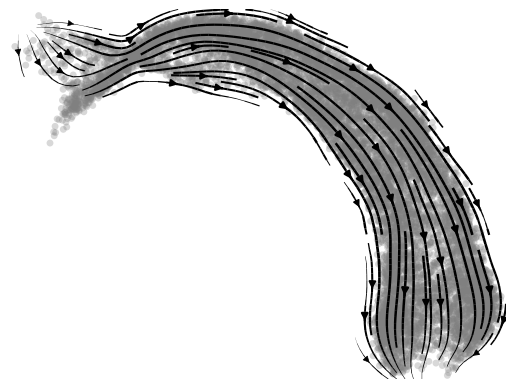

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

We will use an `AnnData` object—the standard “annotated data” container in single-cell analysis. It holds the expression matrix together with cell-level metadata such as cluster labels, time points, and embedding coordinates.

We first split the cells into three pseudo-temporal snapshots (their ordering was computed earlier with the `unitvelo` package). Then we extract the latent time which is an estimate of each cell's differentiation progress based on transcriptional dynamics, and normalise UMAP coordinates.

In [ ]:
# Split the data into three temporal snapshots or marginals
# Gather latent time
latent = adata.obs["latent_time"].to_numpy(float)
# Split data in three snapshots
edges = np.quantile(latent, np.linspace(0, 1, num_times + 1))
bin_id = np.digitize(latent, edges[1:-1], right=False)
adata.obs["snapshots"] = pd.Categorical(bin_id, categories=[0, 1, 2], ordered=True)
# Normalize UMAP coordinates
coords = adata.obsm["X_umap"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_umap_standardized"] = coords
positions = [
    adata.obsm["X_umap_standardized"][adata.obs["snapshots"].cat.codes == k]
    for k in range(num_times)
]

We are going to evaluate how well we do in trajectory inference by leaving out one of the snapshots and measuring W2 distance. To that end, we will keep $t$=0 and $t$=2 as marginals we train on and treat $t$=1 as a left-out marginal to evaluate performance of trained models

In [ ]:
# Create train and test datasets
train_ts = [0, 2]
test_ts = [1]

x_train, v_train = [], []
x_test, v_test = [], []

# TO-DO: Create training and test datasets
#### SOLUTION:
for t in range(num_times):
    if t in train_ts:
        x_train.append(positions[t])
    elif t in test_ts:
        x_test.append(positions[t])
####

x_train = np.stack(x_train)
x_test = np.stack(x_test)

print(f"This is the shape of a training dataset: {x_train.shape}")
print(f"This is the shape of a test dataset: {x_test.shape}")

This is the shape of a training dataset: (2, 3272, 2)
This is the shape of a test dataset: (1, 3271, 2)


You should expect to see following shapes for the training and test datasets -- (2, 3272, 2) and (1, 3271, 2) if you have done the previous part correctly 😊

Let's add some plotting functions so we can visualise our results!

In [ ]:
import seaborn as sns

stages = adata.obs["stage3"]
palette = sns.color_palette("husl", stages.nunique())
lut     = {str(k): v for k, v in zip(stages.cat.categories, palette)}

colours = stages.astype(str).map(lut).to_numpy()

def plot_trajectories(traj, legend=True):
    n = 2000
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.scatter(
        adata.obsm["X_umap_standardized"][:, 0],
        adata.obsm["X_umap_standardized"][:, 1],
        c=colours,
        s=4,
        alpha=1,
    )

    ax.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.05, c="olive")
    ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(15):
        ax.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="red")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])

## Optimal Transport Conditional Flow Matching (OT-CFM)

Here, we will implement a popular model called Optimal Transport Conditional Flow Matching (OT-CFM) which you learnt about in the main part of tutorial 👏 You can also check out the OT-CFM paper [here](https://arxiv.org/abs/2302.00482)

OT-CFM exapands on traditional flow matching framework by conditioning velocity field on $x_0$ and and $x_1$ pairs and computes optimal transport plan $\pi(x_0, x_1)$ to match source to target distribution. You can use the hyperparamaters below as given, but we will have some fun creating velocity field and sampling flow functions below 🌊

In [ ]:
# Model set-up
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim = 2
ot_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), 1e-4)

We will create the following functions:

*   Linear path interpolant: $x_t = (1-t)x_0+tx_1$
*   Conditional Velocity Field: $u_t(x_t|x_0,x_1)=x_1-x_0$

To sample flow, you can use optimal transport coupling from previous tutorial or function available from `torchcfm` package `ot_sampler.sample_plan`


In [ ]:
from torchcfm.optimal_transport import OTPlanSampler

def compute_mu_t(x0, x1, t):
  t = t.reshape(-1, *([1] * (x0.dim() - 1)))
  #TO-DO: Compute linear interpolant xt between source x0 and target x1 distributions
  #### SOLUTION:
  xt = t * x1 + (1 - t) * x0
  ####
  return xt

def sample_xt(x0, x1, t, epsilon, sigma_t):
  mu_t = compute_mu_t(x0, x1, t)
  return mu_t + sigma_t * epsilon

def compute_conditional_flow(x0, x1, t, xt):
  #TO-DO: Compute the conditional velocity field
  #### SOLUTION:
  ut = x1 - x0
  ####
  return ut

def sample_noise_like(x):
  return torch.randn_like(x)

def sample_location_and_conditional_flow(x0, x1, sigma_t):
  t = torch.rand(x0.shape[0]).type_as(x0)
  #TO-DO: Sample flow between x0 and x1
  #### SOLUTION:
  ot_sampler = OTPlanSampler(method="exact")
  x0, x1 = ot_sampler.sample_plan(x0, x1)

  eps = sample_noise_like(x0)
  xt = sample_xt(x0, x1, t, eps, sigma_t)
  ut = compute_conditional_flow(x0, x1, t, xt)
  ####

  return t, xt, ut


We will be training OT-CFM through mini-batching and implementing function below to sample batches and compute flow at $x_t$

In [ ]:
def get_batch(X, batch_size, train_ts, sigma_t):
    ts = []
    xts = []
    uts = []
    for t_start in range(len(train_ts) - 1):

      #TO-DO: Sample batch from X_0 and X_1 snapshots
      #### SOLUTION:
        x0 = (
            torch.from_numpy(X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)])
            .float()
            .to(device)
        )
        x1 = (
            torch.from_numpy(
                X[t_start + 1][np.random.randint(X[t_start + 1].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        ####

        t, xt, ut = sample_location_and_conditional_flow(x0, x1, sigma_t)

        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)

    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    return t, xt, ut

In this part we will implement the training loop used to train OT-CFM model

OT-CFM loss can be calculated as an $L_2$ norm
$L_{OT-CFM} = ||v_t - u_t||$ where $v_t$ represents our velocity field model and $u_t$ is the conditional velocity field we are regressing to

In [ ]:
for i in tqdm(range(10000)):
  #### SOLUTION:
    ot_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(x_train, batch_size, train_ts, sigma)
    vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    ot_cfm_optimizer.step()
  ####

100%|██████████| 10000/10000 [02:38<00:00, 63.21it/s]


As you can see, OT-CFM is quite fast to train! Let's implement the evaluation loop now to assess its performance on the left-out marginal 🚀

We will compute the Wasserstein-2 ($W_2$) distance which measures the square root of the minimal expected squared ground-metric cost taken over all couplings whose marginals are those measures.

To compute $W_2$ between predicted and true distribution at left-out marginal, you can use `torchcfm` built-in function `optimal_transport.wasserstein`.

Avg Wass-1 distance:  0.6605261244763894

----------------------

t            Wass-1 
t2 ---  0.6605261244763894 \\



<Figure size 500x400 with 0 Axes>

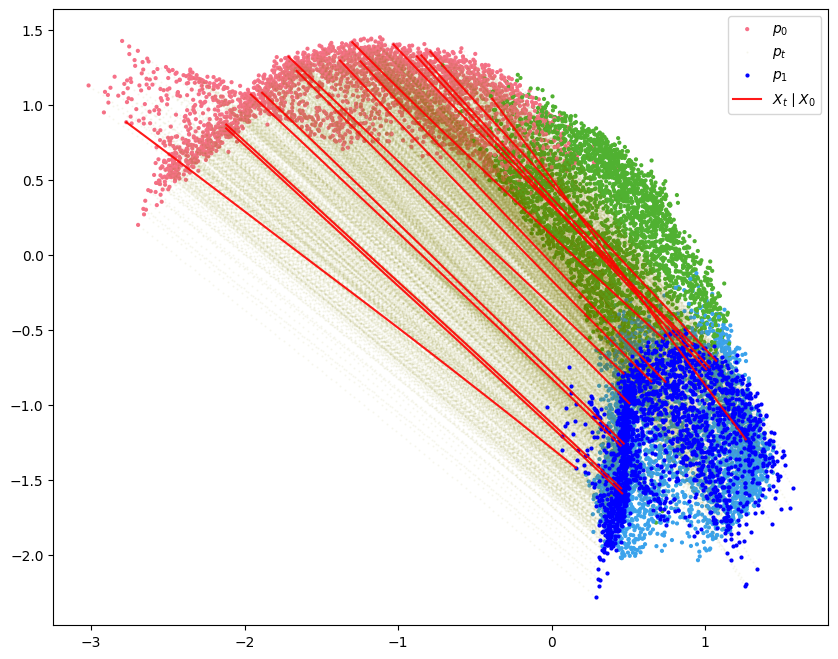

In [ ]:
with torch.no_grad():
    trajs = []
    for t in range(len(train_ts) - 1):
        x0 = torch.from_numpy(x_train[t]).float().to(device)
        x1 = torch.from_numpy(x_train[t + 1]).float().to(device)

        wrapped_model = torch_wrapper(ot_cfm_model)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        out = node.trajectory(
            x0,
            t_span=torch.linspace(t, t + 1, 100),
        ).cpu()

        trajs.append(out)

    traj_ot_cfm = torch.cat(trajs, dim=0)

    plt.figure(figsize=(5, 4))

    wass1 = []
    for t, t_train in enumerate(train_ts[:-1]):
        x0 = torch.from_numpy(positions[t_train]).float().to(device)
        x1 = torch.from_numpy(positions[t_train + 1]).float().to(device)

        wrapped_model = torch_wrapper(ot_cfm_model)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        pred_traj = node.trajectory(
            x0.to(device),
            t_span=torch.linspace(t, t + 1 / 2, 100),
        ).cpu()

        pred = pred_traj[-1]
        wass1.append(optimal_transport.wasserstein(pred, x1.cpu(), power=1))

    wass1 = np.stack(wass1)
    print("Avg Wass-1 distance: ", np.mean(wass1))

    print()
    print("----------------------")
    print()
    print("t            Wass-1 ")
    for i, t_left_out in enumerate(["t2"]):
        print(
            t_left_out + f" ---  {wass1[i]} \\\\"
        )

    print()

    plot_trajectories(
        traj_ot_cfm.cpu().numpy()
    )

OT-CFM manages to match well end-points of single-cell data distributions. However, we can see that the paths don't follow the RNA velocity field which we have previously plotted and miss out points on the left-out marginal 🤯

**Why is that?**

In OT-CFM we use straight path interpolants paired with optimal transport coupling, however most data (especially in biomedical domain) lives on curved manifolds.

In the next part of the tutorial we will explore how we can solve this challenge! 🧭


# Metric Flow Matching

In this part of tutorial we will explore Metric Flow Matching (MFM)🚀

MFM adds a Riemannian metric that makes moving away from real data expensive, so the shortest paths stay close to the observed samples 💡 You can check out the MFM paper [here](https://arxiv.org/abs/2405.14780)

Below is the figure from MFM original paper. Unlike OT-CFM trajectories (in **red**) you can see that the samples follow curvier trajectories with MFM (**in blue**) and stay closer to the data manifold 🙌

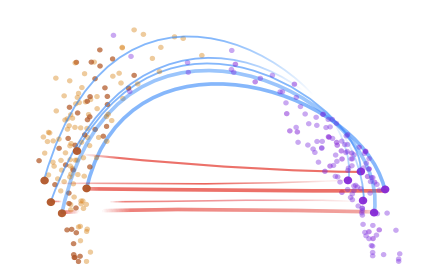

This is achieved by adding a neural network to the straight path interpolant and minimizing the kinetic energy alongside geodesic paths ⚡️

The MFM algorithm consists of **two** parts:

1.   Learning the Riemannian metric
2.   Flow matching to compute transport map between source and target distributions.

In this part of the tutorial we will try implementing this idea!

We will first initiate some parameters to model Riemannian metric used to calculate path interpolant $x_t$.

Specifically, we'll use the **LAND metric** - a diagonal, data-dependent metric that makes it cheaper to move through dense data regions. This encourages paths to bend along the data manifold instead of cutting straight through like they would in normal (Euclidean) space.

This part has already been provided to you, but if you are interested in learning more about computing LAND metric, we encourage you to read section 4 of the MFM paper 😊

In [ ]:
# The hyperparemeters are given to you, which you don't need to change
rho = 0.00005
gamma = 0.15
alpha_metric = 1
batch_size = 256
sigma = 0.01
ot_sampler = OTPlanSampler(method='exact')

In [ ]:
# Riemannian metric utils from original paper repo https://github.com/kksniak/metric-flow-matching
def weighting_function(x, samples, gamma):
    pairwise_sq_diff = (x[:, None, :] - samples[None, :, :]) ** 2
    pairwise_sq_dist = pairwise_sq_diff.sum(-1)
    weights = torch.exp(-pairwise_sq_dist / (2 * gamma**2))
    return weights


def land_metric_tensor(x, samples, gamma, rho):
    weights = weighting_function(x, samples, gamma)  # Shape [B, N]
    differences = samples[None, :, :] - x[:, None, :]  # Shape [B, N, D]
    squared_differences = differences**2  # Shape [B, N, D]

    # Compute the sum of weighted squared differences for each dimension
    M_dd_diag = torch.einsum("bn,bnd->bd", weights, squared_differences) + rho

    # Invert the metric tensor diagonal for each x_t
    M_dd_inv_diag = 1.0 / M_dd_diag  # Shape [B, D] since it's diagonal
    return M_dd_inv_diag


def weighting_function_dt(x, dx_dt, samples, gamma, weights):
    pairwise_sq_diff_dt = (x[:, None, :] - samples[None, :, :]) * dx_dt[:, None, :]
    return -pairwise_sq_diff_dt.sum(-1) * weights / (gamma**2)

def calculate_velocity(x_t, u_t, samples):
    if len(u_t.shape) > 2:
        u_t = u_t.reshape(u_t.shape[0], -1)
        x_t = x_t.reshape(x_t.shape[0], -1)
    M_dd_x_t = (
                land_metric_tensor(x_t, samples, gamma, rho)
                ** alpha_metric
            )
    velocity = torch.sqrt(((u_t**2) * M_dd_x_t).sum(dim=-1))
    return velocity

### Part I: Learning the Riemannian Metric

In MFM, we will consider path interpolants $x_t$ formulated as:

$x_t = (1-t)x_0 + tx_1 + (1-t)t\phi_t(x_0, x_1, t)$

In the formula above:
- the first part $(1-t)x_0 + tx_1$, is a straight line interpolant between the two points
- The term $(1-t)t\phi_t(x_0, x_1, t)$ is a nonlinear correction that lets the path curve and better follow the data manifold where $\phi_t(x_0, x_1, t)$ is a neural network
- If $\phi_t(x_0, x_1, t) = 0$, this reduces to the standard straight-line path used in OT-CFM

The path interpolant is trained such that it minimizes kinetic energy $E_g$ alongside geodesic $\gamma_t$ defined as

$
\gamma_t^{*}
  = \operatorname*{arg\,min}_{\gamma_t:\,\gamma_0 = x_0,\;\gamma_1 = x_1}
    E_g(\gamma_t),
\qquad
E_g(\gamma_t)
  := \mathbb{E}_{t}\!\left[
        \dot{\gamma}_t^{\top}\,
        \mathbf{G}\!\bigl(\gamma_t;D\bigr)\,
        \dot{\gamma}_t
     \right].
$

Here
- $\mathbf{G}\!\bigl(\gamma_t;D\bigr)$ is the learned Riemannian metric, depending on the data $D$
- $\dot{\gamma}_t$ is the velocity (time derivative) of the path

Notice that also by construction of $x_t$, paths are still conditioned between $x_0$ and $x_1$ as we previously saw in OT-CFM. However, unlike OT-CFM, the velocity field here is given by:

$\dot{x_t} = x_1 - x_0 + (1 - 2t)\dot{\phi_t} $

We will use this to implement functions below, you can assume $\phi_t$ is an MLP layer

In order to compute $\dot{x_t}$ you may want to check out `torch.autograd.grad` [documentation](https://docs.pytorch.org/docs/stable/generated/torch.autograd.grad.html) 😃

In [ ]:
def get_xt(t, t_start, x0, x1, geodesic_model=None, sigma=0.0):
  # TO DO: Implement MFM path interpolant
  #### SOLUTION:
  geodesic_output = geodesic_model(torch.cat([x0, x1, t+t_start], dim=-1))
  mu_t = (1 - t) * x0 + t * x1 + t * (1-t) * (geodesic_output)
  epsilon = torch.randn_like(x0)
  x_t = mu_t + torch.sqrt(t*(1-t))*sigma * epsilon
  ####
  return mu_t, x_t, epsilon

def get_xt_xt_dot(t, t_start, t_end, x0, x1, geodesic_model, sigma=0.0):
    with torch.enable_grad():
        t = t[..., None]
        t.requires_grad_(True)
        # TO DO: Derive velocity field
        #### SOLUTION:
        mu_t, xt, eps = get_xt(t, t_start, x0, x1, geodesic_model, sigma=sigma)
        mu_t_dot_list = []
        for i in range(xt.shape[-1]):
            mu_t_dot_list.append(
                torch.autograd.grad(torch.sum(mu_t[..., i]), t, create_graph=True)[0]
            )
        mu_t_dot = torch.cat(mu_t_dot_list, -1)
    ####
    return xt, mu_t_dot, eps

In [ ]:
def get_batch_mfm1(geo, X, batch_size, sigma, train_ts):
    ts = []
    t_orig_list = []
    mu_t_dots = []
    eps_list = []
    xts = []
    uts = []
    velocities = []
    for t_start in range(len(train_ts) - 1):
        t_end = t_start + 1

        # TO DO: Sample x0 and x1
        #### SOLUTION:
        idcs_0 = np.random.randint(X[t_start].shape[0], size=batch_size)
        idcs_1 = np.random.randint(X[t_end].shape[0], size=batch_size)

        x0 = torch.from_numpy(X[t_start][idcs_0]).float().to(device)
        x1 = torch.from_numpy(X[t_end][idcs_1]).float().to(device)
        ####

        # TO DO: Add OT coupling
        #### SOLUTION:
        x0, x1 = ot_sampler.sample_plan(x0, x1)
        ####

        t = torch.rand(x0.shape[0]).type_as(x0)
        t_o = t

        # TO DO: Compute path interpolant and velocity field
        #### SOLUTION:
        xt, mu_t_dot, eps = get_xt_xt_dot(t, t_start, t_end, x0, x1, geo, sigma=sigma)
        ut = mu_t_dot
        ####

        samples = torch.cat([torch.from_numpy(X[t_start]).float().to(device), torch.from_numpy(X[t_end]).float().to(device)], dim=0)
        vel = calculate_velocity(xt, ut, samples)

        t_orig_list.append(t_o)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
        mu_t_dots.append(mu_t_dot)
        eps_list.append(eps)
        velocities.append(vel)

    t_orig = torch.cat(t_orig_list)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    mu_t_dot = torch.cat(mu_t_dots)
    eps = torch.cat(eps_list)
    vel = torch.cat(velocities)

    return t_orig, t, xt, ut, mu_t_dot, eps, vel

In [ ]:
# Model we will use to train geodesic network
geo_model = MLP(dim=dim*2, out_dim=dim, time_varying=True, w=64).to(device) # this is the neural network \phi_t
geo_optimizer = torch.optim.AdamW(geo_model.parameters(), 1e-4)

We will implement the training loop with loss $L_{MFM_1}$ derived with respect to minimizing kinetic energy, where velocity is computed using geodesic metric (`vel` variable in the `get_batch_mfm1` function).

100%|██████████| 2000/2000 [00:45<00:00, 44.02it/s]


Text(0, 0.5, 'Loss')

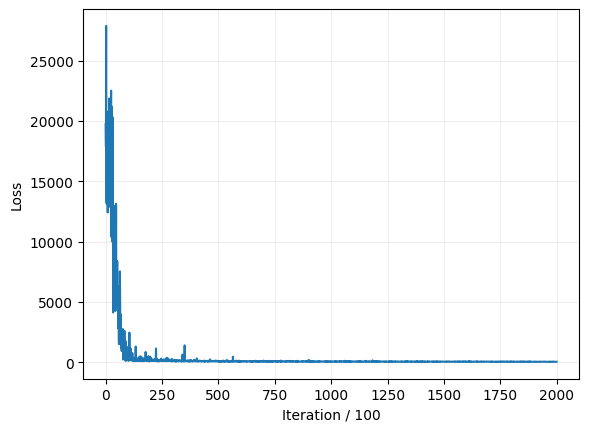

In [ ]:
# Implement the training loop
train_loss = []
start_time = time.time()

for i in tqdm(range(2000)):
  # TO DO: Implement the training loop with loss equal to kinetic energy
  #### SOLUTION:
    geo_optimizer.zero_grad()
    t_orig, t, xt, ut, mu_t_dot, eps, vel = get_batch_mfm1(geo_model, x_train, batch_size, sigma, train_ts)

    loss = torch.mean(vel ** 2) #* (1/scaling)

    loss.backward()
    geo_optimizer.step()

    train_loss.append(loss.cpu().item())
  ####

end_time = time.time()

train_time_mfm_geo = end_time - start_time

plt.plot(train_loss)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")
plt.ylabel("Loss")

### Part II: Flow Matching

In this part we will assume same set-up as before in OT-CFM. However note that the field you will be regressing to is given as $u_t = \dot{x_t}$.

We will be computing the loss such that it minimises the $L_2$ loss defined as $L_{MFM_2} = ||v_t - u_t||$. You can assume that $v_t$ is parametrized as an MLP.

In [ ]:
# Hyperpar for algo 2
batch_size = 256
sigma = 0.01
alpha = 1.0
vel_model = MLP(dim=dim, time_varying=True, w=64).to(device)
vel_optimizer = torch.optim.Adam(vel_model.parameters(), 1e-4)

In [ ]:
# TO DO
def get_batch_mfm2(geo, X, V, batch_size, sigma, ts_train):
    ts = []
    t_orig_list = []
    mu_t_dots = []
    eps_list = []
    xts = []
    uts = []

    for t_start in range(len(ts_train) - 1):
        t_end = t_start + 1

        # TO DO: Sample x0 and x1
        #### SOLUTION:
        idcs_0 = np.random.randint(X[t_start].shape[0], size=batch_size)
        idcs_1 = np.random.randint(X[t_end].shape[0], size=batch_size)

        x0 = torch.from_numpy(X[t_start][idcs_0]).float().to(device)
        x1 = torch.from_numpy(X[t_end][idcs_1]).float().to(device)
        ####

        # TO DO: Add OT coupling
        #### SOLUTION:
        x0, x1 = ot_sampler.sample_plan(x0, x1)
        ####

        t = torch.rand(x0.shape[0]).type_as(x0)
        t_o = t

        # TO DO: Compute path interpolant and velocity field
        #### SOLUTION:
        xt, mu_t_dot, eps = get_xt_xt_dot(t, t_start, t_end, x0, x1, geo, sigma=sigma)
        ut = mu_t_dot
        ####

        t_orig_list.append(t_o)
        ts.append(t + t_start)
        xts.append(xt)
        mu_t_dots.append(mu_t_dot)
        eps_list.append(eps)
        uts.append(ut)

    t_orig = torch.cat(t_orig_list)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    mu_t_dot = torch.cat(mu_t_dots)
    eps = torch.cat(eps_list)
    ut = torch.cat(uts)

    return t_orig, t, xt, mu_t_dot, eps, ut

100%|██████████| 10000/10000 [03:28<00:00, 47.98it/s]


Text(0.5, 0, 'Iteration / 100')

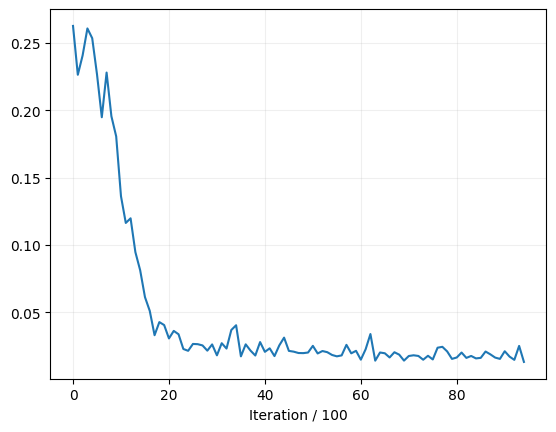

In [ ]:
# TO DO
vel_loss = []

start_time = time.time()
ot_sampler = OTPlanSampler(method='exact')
for i in tqdm(range(10000)):
  # TO DO: Implement the training loop with respect to minimising L2 loss
  #### SOLUTION:
    vel_optimizer.zero_grad()

    t_orig, t, xt, mu_t_dot, eps, ut = get_batch_mfm2(geo_model, x_train, v_train, batch_size, sigma, train_ts)
    vt = vel_model(torch.cat([xt.detach(), t[:, None]], dim=-1))

    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    vel_optimizer.step()
  ####

    if i % 100 == 0:
        vel_loss.append(loss.cpu().item())

end_time = time.time()

train_time_mfm_vel = end_time - start_time

plt.plot(vel_loss[5:])
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")

Avg Wass-1 distance:  0.2886723689332721

----------------------

t            Wass-1 
t2 ---  0.2886723689332721 \\



<Figure size 500x400 with 0 Axes>

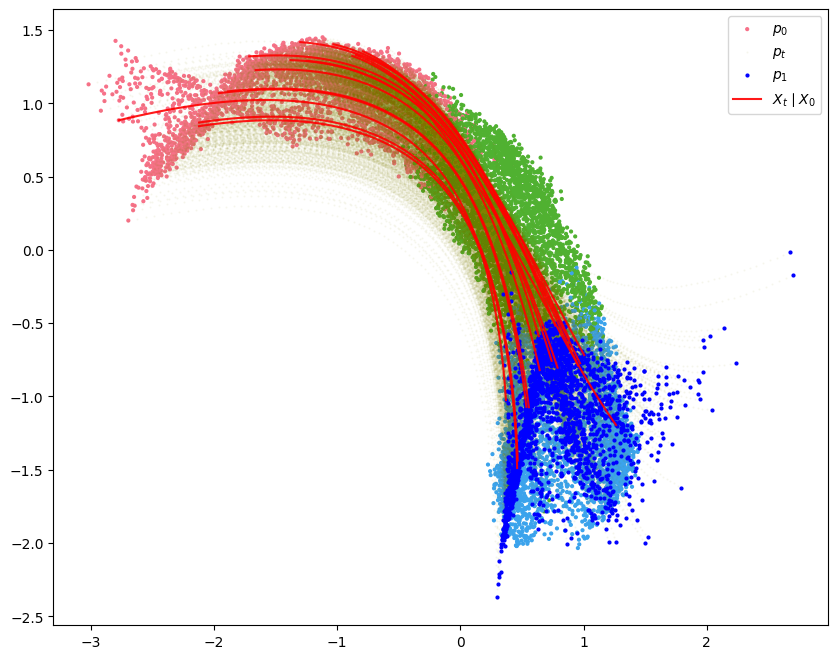

In [ ]:
with torch.no_grad():
    trajs = []
    for t in range(len(train_ts) - 1):
        x0 = torch.from_numpy(x_train[t]).float().to(device)
        x1 = torch.from_numpy(x_train[t + 1]).float().to(device)

        wrapped_model = torch_wrapper(vel_model)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        out = node.trajectory(
            x0,
            t_span=torch.linspace(t, t + 1, 100),
        ).cpu()

        trajs.append(out)

    traj_ot_cfm = torch.cat(trajs, dim=0)

    plt.figure(figsize=(5, 4))

    wass1 = []
    for t, t_train in enumerate(train_ts[:-1]):
        x0 = torch.from_numpy(positions[t_train]).float().to(device)
        x1 = torch.from_numpy(positions[t_train + 1]).float().to(device)

        wrapped_model = torch_wrapper(vel_model)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        pred_traj = node.trajectory(
            x0.to(device),
            t_span=torch.linspace(t, t + 1 / 2, 100),
        ).cpu()

        pred = pred_traj[-1]
        wass1.append(optimal_transport.wasserstein(pred, x1.cpu(), power=1))

    wass1 = np.stack(wass1)
    print("Avg Wass-1 distance: ", np.mean(wass1))

    print()
    print("----------------------")
    print()
    print("t            Wass-1 ")
    for i, t_left_out in enumerate(["t2"]):
        print(
            t_left_out + f" ---  {wass1[i]} \\\\"
        )

    print()

    plot_trajectories(
        traj_ot_cfm.cpu().numpy()
    )

You can see that by including data manifold paths are now bending closer to the RNA velocity field! 🙌

### Congrats you made it to the end of the tutorial! 🎉🎉🎉 We hope you had some fun and please feel free to reach out to us if you are further interested in this topic!